In [1]:
import pandas as pd
from datetime import datetime as dt
import sys

In [2]:
dat = None

In [3]:
dat = pd.read_csv("/home/michael/Documents/csv_data/BTC_ETH.csv")

In [38]:
dat.head()

,Unnamed: 0,baseVolume,high24hr,highestBid,id,isFrozen,last,low24hr,lowestAsk,pair_id,percentChange,quoteVolume,time
0,0,37358.253282,0.1204,0.113916,148,0,0.114100,0.1105,0.114100,BTC_ETH,-0.012058,321874.117087,2017-06-30 18:54:20.655554
1,1,37415.448498,0.1204,0.114000,148,0,0.114100,0.1105,0.114100,BTC_ETH,-0.011279,322377.191431,2017-06-30 18:54:30.737082
2,2,37415.448498,0.1204,0.114024,148,0,0.114024,0.1105,0.114100,BTC_ETH,-0.014293,322377.191431,2017-06-30 18:54:40.813797
3,3,37415.448498,0.1204,0.114088,148,0,0.114100,0.1105,0.114100,BTC_ETH,-0.011986,322377.191431,2017-06-30 18:54:50.884140
4,4,37415.448498,0.1204,0.114088,148,0,0.114088,0.1105,0.114298,BTC_ETH,-0.012891,322377.191431,2017-06-30 18:55:00.957007


In [30]:
price = dat.loc[:,"last"].values
price.pop("last")

AttributeError: 'numpy.ndarray' object has no attribute 'pop'

In [5]:
time = dat.loc[:,"time"].values
#time = [dt.strptime(t,"%Y-%m-%d %H:%M:%S.%f") for t in time]


In [8]:
time3 = [dt.strptime(t,"%Y-%m-%d %H:%M:%S.%f") for t in time]
price = dat.loc[:,"last"].values
aapl = pd.DataFrame({"prices":price},index=time3)


In [13]:
# Initialize the short and long windows

import numpy as np
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl.loc[:,'prices'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl.loc[:,'prices'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

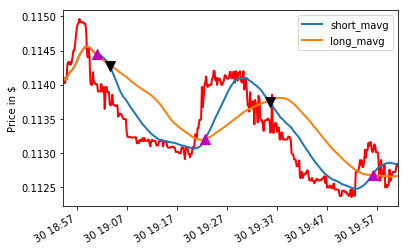

In [18]:

import matplotlib.pyplot as plt
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl.loc[:,'prices'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()



In [22]:

# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(aapl.loc[:,'prices'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(aapl.loc[:,'prices'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl.loc[:,'prices'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()



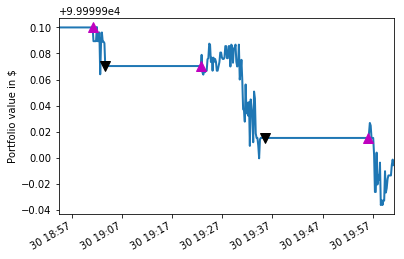

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()